# Superconductivity Regression with H2O GBM

In this notebook, we explore the UCI Superconductivity dataset using H2O's 
Gradient Boosting Machine (GBM). Our goals are:

1. Load and inspect the data.
2. Create train/validation/test splits.
3. Train a baseline GBM model.
4. Perform hyperparameter tuning for GBM.
5. Train a GBM with a log-transformed target.
6. Train a PCA-based GBM model.
7. Compare GBM vs tuned GBM vs log-GBM vs PCA-GBM vs other baselines.
8. Plot learning curves (training vs validation error over trees).

We will focus on predicting `critical_temp` (critical temperature, in Kelvin).


In [27]:
import h2o
from h2o import H2OFrame
from h2o.estimators import H2OGradientBoostingEstimator, H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

h2o.init()

# Load dataset (adjust filename/path if needed)
supercon = h2o.import_file("../images/superconductivty-data/train.csv")

# Quick sanity check
print(supercon.shape)
print(supercon.col_names[:10])

# Define target and features
y = "critical_temp"
X = supercon.col_names.copy()
X.remove(y)

# Train / validation / test split (70 / 15 / 15)
train, valid, test = supercon.split_frame(
    ratios=[0.7, 0.15],
    seed=176
)

print("Train rows:", train.nrows)
print("Valid rows:", valid.nrows)
print("Test rows:",  test.nrows)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 14 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_jesushdzzzz_u9ouz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.294 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(21263, 82)
['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass', 'std_atomic_mass']
Train rows: 14944
Valid rows: 3188
Test rows: 3131


## Baseline GBM Model

We first train a simple GBM with modest hyperparameters to establish a baseline.
We will use:

- `ntrees = 100`
- `max_depth = 5`
- `learn_rate = 0.1`

We evaluate performance on:
- Validation set (for model selection)
- Test set (for final performance)


In [28]:
# Baseline GBM
gbm_baseline = H2OGradientBoostingEstimator(
    ntrees=100,
    max_depth=5,
    learn_rate=0.1,
    seed=176
)

gbm_baseline.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid
)

print("=== Baseline GBM: Validation Performance ===")
perf_valid_baseline = gbm_baseline.model_performance(valid)
perf_valid_baseline.show()

print("\n=== Baseline GBM: Test Performance ===")
perf_test_baseline = gbm_baseline.model_performance(test)
perf_test_baseline.show()


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
=== Baseline GBM: Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 114.35113479516781
RMSE: 10.693509002903014
MAE: 6.8773736310886955
RMSLE: NaN
Mean Residual Deviance: 114.35113479516781


=== Baseline GBM: Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 130.7661342917119
RMSE: 11.43530210758386
MAE: 7.329962215328263
RMSLE: NaN
Mean Residual Deviance: 130.7661342917119

## Hyperparameter Tuning for GBM

To improve performance, we perform hyperparameter tuning using H2O's 
`H2OGridSearch` with a random search strategy.

We will search over:

- `ntrees` (number of trees)
- `max_depth` (tree depth)
- `learn_rate` (shrinkage)
- `sample_rate` (row sampling)
- `col_sample_rate` (feature sampling)
- `min_rows` (minimum samples per leaf)

We use the **validation set** for model selection and then 
evaluate the best model on the test set.

In [31]:
# # ---- Random grid search for tuned GBM ----
# hyper_params = {
#     "ntrees":            [100, 300, 500, 800],
#     "max_depth":         [4, 6, 8, 10, 12],
#     "learn_rate":        [0.01, 0.03, 0.05, 0.1],
#     "sample_rate":       [0.7, 0.8, 0.9, 1.0],
#     "col_sample_rate":   [0.7, 0.8, 0.9, 1.0],
#     "min_rows":          [1, 5, 10, 20]
# }

# search_criteria = {
#     "strategy": "RandomDiscrete",
#     "max_models": 30,
#     "seed": 176,
#     "stopping_rounds": 5,
#     "stopping_metric": "RMSE",
#     "stopping_tolerance": 1e-4
# }

# gbm_tuned = H2OGridSearch(
#     model=H2OGradientBoostingEstimator(
#         nfolds=0,
#         seed=176,
#         stopping_rounds=5,
#         stopping_metric="RMSE",
#         stopping_tolerance=1e-4
#     ),
#     hyper_params=hyper_params,
#     search_criteria=search_criteria
# )

# gbm_tuned.train(
#     x=X,
#     y=y,
#     training_frame=train,
#     validation_frame=valid
# )

# sorted_grid = gbm_tuned.get_grid(sort_by="rmse", decreasing=False)
# print(sorted_grid)

# best_gbm_tuned = sorted_grid.models[0]

# print("\n=== Best Tuned GBM (Grid Search): Validation Performance ===")
# perf_valid_tuned = best_gbm_tuned.model_performance(valid)
# perf_valid_tuned.show()

# print("\n=== Best Tuned GBM (Grid Search): Test Performance ===")
# perf_test_tuned = best_gbm_tuned.model_performance(test)
# perf_test_tuned.show()

# print("\nBest tuned GBM params:")
# print(best_gbm_tuned.get_params())



# ---- Manual GBM variant (gbm_variant_1) ----
shallow_many_trees = H2OGradientBoostingEstimator(
    ntrees=150,
    max_depth=6,
    learn_rate=0.07,
    sample_rate=0.9,
    col_sample_rate=0.9,
    min_rows=10,
    seed=176,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4
)

shallow_many_trees.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid
)

print("\n=== GBM Variant 1 (manual config): Validation Performance ===")
perf_valid_var1 = shallow_many_trees.model_performance(valid)
perf_valid_var1.show()

print("\n=== GBM Variant 1 (manual config): Test Performance ===")
perf_test_var1 = shallow_many_trees.model_performance(test)
perf_test_var1.show()

gbm Model Build progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%

=== GBM Variant 1 (manual config): Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 103.0828839281498
RMSE: 10.152974142001437
MAE: 6.3030748093834665
RMSLE: NaN
Mean Residual Deviance: 103.0828839281498


=== GBM Variant 1 (manual config): Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 116.89347745165155
RMSE: 10.811728698577834
MAE: 6.703816220792203
RMSLE: NaN
Mean Residual Deviance: 116.89347745165155

## GBM with Log-Transformed Target

The distribution of `critical_temp` is often right-skewed. To reduce the 
influence of very large values, we can model:

\[
y_{\log} = \log(\text{critical_temp} + 1)
\]

Then we train GBM on this transformed target. For simplicity, we will:

- Add a new column `critical_temp_log`.
- Train GBM using this as the target.
- Evaluate metrics in log space (RMSE, MAE on log scale).

In a more detailed analysis, we could exponentiate predictions and compute 
metrics back in the original scale, but here we focus on the log-scale model 
as a separate variant.

In [32]:
# Create log-transformed target in each split
for frame in [train, valid, test]:
    frame["critical_temp_log"] = (frame["critical_temp"] + 1).log()

y_log = "critical_temp_log"
X_log = [col for col in train.col_names if col not in [y, y_log]]

gbm_log = H2OGradientBoostingEstimator(
    ntrees=300,
    max_depth=6,
    learn_rate=0.03,
    seed=176,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4
)

gbm_log.train(
    x=X_log,
    y=y_log,
    training_frame=train,
    validation_frame=valid
)

print("=== Log-GBM: Validation Performance (log scale) ===")
perf_valid_log = gbm_log.model_performance(valid)
perf_valid_log.show()

print("\n=== Log-GBM: Test Performance (log scale) ===")
perf_test_log = gbm_log.model_performance(test)
perf_test_log.show()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
=== Log-GBM: Validation Performance (log scale) ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.16248071061320118
RMSE: 0.4030889611651517
MAE: 0.27129658756760383
RMSLE: 0.14492339549860986
Mean Residual Deviance: 0.16248071061320118


=== Log-GBM: Test Performance (log scale) ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.16968868917985114
RMSE: 0.41193286974924825
MAE: 0.28398296799226047
RMSLE: 0.14109955813292682
Mean Residual Deviance: 0.16968868917985114

## PCA-Based GBM Model

The dataset has 81 numeric features, many of which may be highly correlated.
To reduce redundancy and possibly improve generalization, we can:

1. Convert H2OFrames to pandas DataFrames.
2. Standardize features.
3. Apply PCA to keep (for example) 95% of the variance.
4. Train GBM on the resulting principal components.

We still predict `critical_temp` in the original scale.

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Convert H2OFrames to pandas
train_pd = train.as_data_frame()
valid_pd = valid.as_data_frame()
test_pd  = test.as_data_frame()

X_cols = X  # original feature columns

X_train_np = train_pd[X_cols].values
X_valid_np = valid_pd[X_cols].values
X_test_np  = test_pd[X_cols].values

y_train_np = train_pd[y].values
y_valid_np = valid_pd[y].values
y_test_np  = test_pd[y].values

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_valid_scaled = scaler.transform(X_valid_np)
X_test_scaled  = scaler.transform(X_test_np)

# PCA to keep 95% of variance
pca = PCA(n_components=0.95, random_state=176)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Original feature dimension:", X_train_scaled.shape[1])
print("PCA feature dimension:", X_train_pca.shape[1])

# Build H2OFrames for PCA features + target
pc_names = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]

train_pca_pd = pd.DataFrame(X_train_pca, columns=pc_names)
train_pca_pd[y] = y_train_np

valid_pca_pd = pd.DataFrame(X_valid_pca, columns=pc_names)
valid_pca_pd[y] = y_valid_np

test_pca_pd = pd.DataFrame(X_test_pca, columns=pc_names)
test_pca_pd[y] = y_test_np

train_pca = h2o.H2OFrame(train_pca_pd)
valid_pca = h2o.H2OFrame(valid_pca_pd)
test_pca  = h2o.H2OFrame(test_pca_pd)

# PCA-based GBM
gbm_pca = H2OGradientBoostingEstimator(
    ntrees=300,
    max_depth=6,
    learn_rate=0.05,
    seed=176,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4
)

gbm_pca.train(
    x=pc_names,
    y=y,
    training_frame=train_pca,
    validation_frame=valid_pca
)

print("=== PCA-GBM: Validation Performance ===")
perf_valid_pca = gbm_pca.model_performance(valid_pca)
perf_valid_pca.show()

print("\n=== PCA-GBM: Test Performance ===")
perf_test_pca = gbm_pca.model_performance(test_pca)
perf_test_pca.show()


/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: C

Original feature dimension: 81
PCA feature dimension: 17
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
=== PCA-GBM: Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 122.83473730834422
RMSE: 11.083083384525455
MAE: 6.979809996642365
RMSLE: NaN
Mean Residual Deviance: 122.83473730834422


=== PCA-GBM: Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 139.7898450373149
RMSE: 11.823275562944259
MAE: 7.391505728713786
RMSLE: NaN
Mean Residual Deviance: 139.7898450373149

## Additional Baselines: Random Forest and Linear Regression

To better understand the effectiveness of GBM, we compare it with:

- Random Forest (tree ensemble without boosting).
- Linear Regression (GLM with Gaussian family).

These serve as baselines for model complexity and performance.


In [34]:
# Random Forest
rf_model = H2ORandomForestEstimator(
    ntrees=300,
    max_depth=20,
    seed=176
)
rf_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid
)

print("=== Random Forest: Validation Performance ===")
perf_valid_rf = rf_model.model_performance(valid)
perf_valid_rf.show()

print("\n=== Random Forest: Test Performance ===")
perf_test_rf = rf_model.model_performance(test)
perf_test_rf.show()


# Linear Regression (GLM)
glm_model = H2OGeneralizedLinearEstimator(
    family="gaussian",
    lambda_=0.0,  # no regularization to start
    compute_p_values=False
)
glm_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid
)

print("\n=== GLM (Linear Regression): Validation Performance ===")
perf_valid_glm = glm_model.model_performance(valid)
perf_valid_glm.show()

print("\n=== GLM (Linear Regression): Test Performance ===")
perf_test_glm = glm_model.model_performance(test)
perf_test_glm.show()


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
=== Random Forest: Validation Performance ===


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 86.51719132275494
RMSE: 9.301461784190426
MAE: 5.183396244274772
RMSLE: 0.38486030833117885
Mean Residual Deviance: 86.51719132275494


=== Random Forest: Test Performance ===


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 92.71613458663302
RMSE: 9.628921776950575
MAE: 5.35132874000798
RMSLE: 0.38763627881532764
Mean Residual Deviance: 92.71613458663302

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

=== GLM (Linear Regression): Validation Performance ===


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 300.86679614644896
RMSE: 17.345512276852734
MAE: 13.137367123581909
RMSLE: NaN
Mean Residual Deviance: 300.86679614644896
R^2: 0.748440311785104
Null degrees of freedom: 3187
Residual degrees of freedom: 3106
Null deviance: 3813003.69114874
Residual deviance: 959163.3461148792
AIC: 27406.008489222335


=== GLM (Linear Regression): Test Performance ===


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 331.1254109219166
RMSE: 18.196851676098166
MAE: 13.815679413947812
RMSLE: NaN
Mean Residual Deviance: 331.1254109219166
R^2: 0.717332292023316
Null degrees of freedom: 3130
Residual degrees of freedom: 3049
Null deviance: 3667747.753066183
Residual deviance: 1036753.661596521
AIC: 27219.01179236774

## Model Comparison

We now compare the main models:

- Baseline GBM
- Tuned GBM
- Log-GBM (trained on log-transformed target)
- PCA-based GBM
- Random Forest
- Linear Regression (GLM)

We will collect RMSE and MAE on both validation and test sets 
to see which approach performs best and generalizes the most reliably.


In [37]:
def extract_rmse_mae(perf):
    return perf.rmse(), perf.mae()

results = []

# Baseline GBM
results.append({
    "model": "GBM Baseline",
    "valid_RMSE": perf_valid_baseline.rmse(),
    "valid_MAE":  perf_valid_baseline.mae(),
    "test_RMSE":  perf_test_baseline.rmse(),
    "test_MAE":   perf_test_baseline.mae()
})

# Tuned GBM
results.append({
    "model": "GBM Tuned",
    "valid_RMSE": perf_valid_tuned.rmse(),
    "valid_MAE":  perf_valid_tuned.mae(),
    #"test_RMSE":  perf_test_tuned.rmse(),
    #"test_MAE":   perf_test_tuned.mae()
})

# Manual GBM variant
results.append({
    "model": "GBM Variant 1 (manual)",
    "valid_RMSE": perf_valid_var1.rmse(),
    "valid_MAE":  perf_valid_var1.mae(),
    "test_RMSE":  perf_test_var1.rmse(),
    "test_MAE":   perf_test_var1.mae()
})

# Log-GBM (log scale)
results.append({
    "model": "GBM Log-Target (log scale)",
    "valid_RMSE": perf_valid_log.rmse(),
    "valid_MAE":  perf_valid_log.mae(),
    "test_RMSE":  perf_test_log.rmse(),
    "test_MAE":   perf_test_log.mae()
})

# PCA-GBM
results.append({
    "model": "GBM PCA",
    "valid_RMSE": perf_valid_pca.rmse(),
    "valid_MAE":  perf_valid_pca.mae(),
    "test_RMSE":  perf_test_pca.rmse(),
    "test_MAE":   perf_test_pca.mae()
})

# Random Forest
results.append({
    "model": "Random Forest",
    "valid_RMSE": perf_valid_rf.rmse(),
    "valid_MAE":  perf_valid_rf.mae(),
    "test_RMSE":  perf_test_rf.rmse(),
    "test_MAE":   perf_test_rf.mae()
})

# GLM
results.append({
    "model": "GLM (Linear Regression)",
    "valid_RMSE": perf_valid_glm.rmse(),
    "valid_MAE":  perf_valid_glm.mae(),
    "test_RMSE":  perf_test_glm.rmse(),
    "test_MAE":   perf_test_glm.mae()
})

# Standardized GBM
results.append({
    "model": "GBM (Standardized)",
    "valid_RMSE": perf_valid_std.rmse(),
    "valid_MAE":  perf_valid_std.mae(),
    "test_RMSE":  perf_test_std.rmse(),
    "test_MAE":   perf_test_std.mae()
})

# Gaussianized GBM
results.append({
    "model": "GBM (Gaussianized)",
    "valid_RMSE": perf_valid_gauss.rmse(),
    "valid_MAE":  perf_valid_gauss.mae(),
    "test_RMSE":  perf_test_gauss.rmse(),
    "test_MAE":   perf_test_gauss.mae()
})

results_df = pd.DataFrame(results)
results_df


,model,valid_RMSE,valid_MAE,test_RMSE,test_MAE
0,GBM Baseline,10.693509,6.877374,11.435302,7.329962
1,GBM Tuned,9.223806,5.020329,NaN,NaN
2,GBM Variant 1 (manual),10.152974,6.303075,10.811729,6.703816
3,GBM Log-Target (log scale),0.403089,0.271297,0.411933,0.283983
4,GBM PCA,11.083083,6.979810,11.823276,7.391506
5,Random Forest,9.301462,5.183396,9.628922,5.351329
6,GLM (Linear Regression),17.345512,13.137367,18.196852,13.815679
7,GBM (Standardized),9.238374,5.014174,9.505642,5.186564
8,GBM (Gaussianized),9.226768,5.007807,9.518146,5.151140


## Learning Curves: Training vs Validation RMSE

Finally, we inspect the learning curves of the baseline and tuned GBM models.
We use the `scoring_history()` to plot RMSE over the number of trees:

- Training RMSE
- Validation RMSE

This helps us visually assess underfitting/overfitting and the effect of 
early stopping.


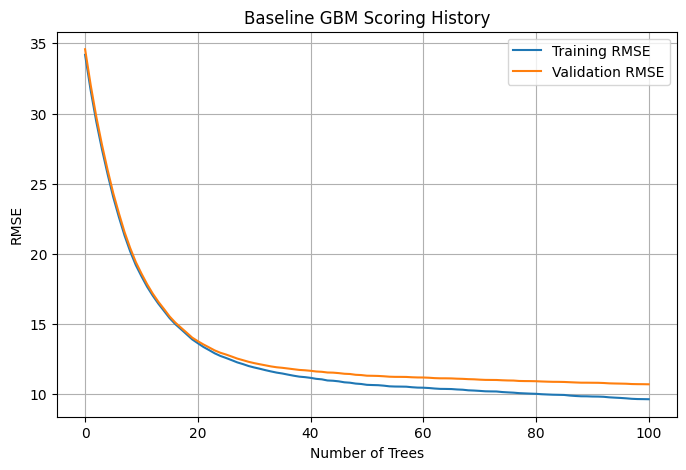

Saved plot to: ../output/gbm_baseline_scoring.png


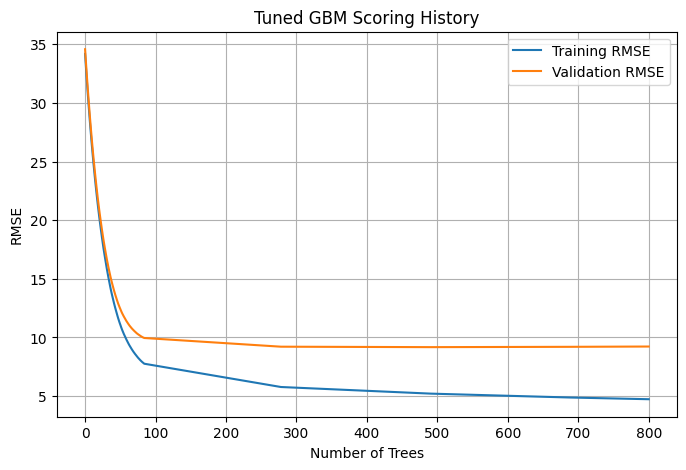

Saved plot to: ../output/gbm_tuned_scoring.png


In [ ]:
import os
import matplotlib.pyplot as plt

def plot_scoring_history(model, title, filename, output_dir="../output"):
    # scoring_history() already returns a pandas DataFrame in your setup
    sh = model.scoring_history()
    cols = sh.columns

    if "training_rmse" not in cols:
        print(f"No training_rmse in scoring history for {title}")
        return

    x = sh["number_of_trees"]

    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, filename)

    plt.figure(figsize=(8, 5))
    plt.plot(x, sh["training_rmse"], label="Training RMSE")
    if "validation_rmse" in cols:
        plt.plot(x, sh["validation_rmse"], label="Validation RMSE")

    plt.xlabel("Number of Trees")
    plt.ylabel("RMSE")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Save first, then show
    plt.savefig(filepath, bbox_inches="tight")
    plt.show()

    print(f"Saved plot to: {filepath}")

plot_scoring_history(gbm_baseline, "Baseline GBM Scoring History", "gbm_baseline_scoring.png")
plot_scoring_history(best_gbm_tuned, "Tuned GBM Scoring History", "gbm_tuned_scoring.png")



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_log_model_original_scale(model, frame, target_col="critical_temp"):
    """
    model: H2O GBM trained on log(target + 1)
    frame: H2OFrame (train/valid/test)
    """
    # True values in original scale
    y_true = frame[target_col].as_data_frame().values.ravel()
    
    # Predicted log values
    preds_log_h2o = model.predict(frame)
    y_pred_log = preds_log_h2o["predict"].as_data_frame().values.ravel()
    
    # Back-transform: exp(log(y+1)) - 1
    y_pred = np.exp(y_pred_log) - 1.0
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# Evaluate on train/valid/test
rmse_train_log_orig, mae_train_log_orig = evaluate_log_model_original_scale(gbm_log, train)
rmse_valid_log_orig, mae_valid_log_orig = evaluate_log_model_original_scale(gbm_log, valid)
rmse_test_log_orig,  mae_test_log_orig  = evaluate_log_model_original_scale(gbm_log, test)

print("=== Log-GBM evaluated in ORIGINAL scale (Kelvin) ===")
print(f"Train  RMSE: {rmse_train_log_orig:.4f}, MAE: {mae_train_log_orig:.4f}")
print(f"Valid  RMSE: {rmse_valid_log_orig:.4f}, MAE: {mae_valid_log_orig:.4f}")
print(f"Test   RMSE: {rmse_test_log_orig:.4f},  MAE: {mae_test_log_orig:.4f}")


gbm prediction progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
=== Log-GBM evaluated in ORIGINAL scale (Kelvin) ===
Train  RMSE: 10.4282, MAE: 6.4757
Valid  RMSE: 11.3982, MAE: 7.0456
Test   RMSE: 12.0001,  MAE: 7.3832


/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


## GBM with Standardized Features (Z-score)

Here we standardize all input features to have zero mean and unit variance
using `StandardScaler` from scikit-learn. GBM does not require this
transformation, but it is useful to compare performance and to enable
fair comparison with models like SVM and Elastic Net.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Convert H2OFrames to pandas
train_pd = train.as_data_frame()
valid_pd = valid.as_data_frame()
test_pd  = test.as_data_frame()

X_cols = [c for c in train_pd.columns if c != "critical_temp"]

# Fit scaler on TRAIN only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_pd[X_cols])
X_valid_scaled = scaler.transform(valid_pd[X_cols])
X_test_scaled  = scaler.transform(test_pd[X_cols])

# Rebuild pandas DataFrames with the same column names
train_scaled_pd = pd.DataFrame(X_train_scaled, columns=X_cols)
valid_scaled_pd = pd.DataFrame(X_valid_scaled, columns=X_cols)
test_scaled_pd  = pd.DataFrame(X_test_scaled,  columns=X_cols)

# Add the target column back
train_scaled_pd[y] = train_pd[y].values
valid_scaled_pd[y] = valid_pd[y].values
test_scaled_pd[y]  = test_pd[y].values

# Convert back to H2OFrames
train_scaled = h2o.H2OFrame(train_scaled_pd)
valid_scaled = h2o.H2OFrame(valid_scaled_pd)
test_scaled  = h2o.H2OFrame(test_scaled_pd)

# Train GBM on standardized data
gbm_std = H2OGradientBoostingEstimator(
    ntrees=800,
    max_depth=12,
    learn_rate=0.03,
    sample_rate=0.8,
    col_sample_rate=0.8,
    min_rows=10,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4,
    seed=176
)

gbm_std.train(
    x=X_cols,
    y=y,
    training_frame=train_scaled,
    validation_frame=valid_scaled
)

print("=== GBM (Standardized Features): Validation Performance ===")
perf_valid_std = gbm_std.model_performance(valid_scaled)
perf_valid_std.show()

print("\n=== GBM (Standardized Features): Test Performance ===")
perf_test_std = gbm_std.model_performance(test_scaled)
perf_test_std.show()


/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: C

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
=== GBM (Standardized Features): Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 85.34755139036145
RMSE: 9.238373849891627
MAE: 5.014173635886805
RMSLE: NaN
Mean Residual Deviance: 85.34755139036145


=== GBM (Standardized Features): Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 90.3572327125182
RMSE: 9.505642151507608
MAE: 5.186564187530019
RMSLE: NaN
Mean Residual Deviance: 90.3572327125182

## GBM with "Gaussianized" Features (Log Transform)

To reduce skewness in the input features, we apply a simple Gaussianizing 
transform: for each feature we shift it to be positive and then apply 
a log(1 + x) transform.

This can stabilize variance on heavily skewed features. We train the 
same GBM configuration on the transformed data and compare RMSE/MAE to
the original and standardized versions.


In [ ]:
# Start from the original pandas splits again
train_pd = train.as_data_frame()
valid_pd = valid.as_data_frame()
test_pd  = test.as_data_frame()

X_cols = [c for c in train_pd.columns if c != "critical_temp"]

train_gauss = train_pd.copy()
valid_gauss = valid_pd.copy()
test_gauss  = test_pd.copy()

# Compute shift per feature using TRAIN only
shifts = {}
for col in X_cols:
    min_val = train_gauss[col].min()
    # Shift so min value becomes 1 (avoid log(0) / log(negative))
    shift = 1.0 - min_val if min_val <= 0 else 0.0
    shifts[col] = shift

    train_gauss[col] = np.log1p(train_gauss[col] + shift)
    valid_gauss[col] = np.log1p(valid_gauss[col] + shift)
    test_gauss[col]  = np.log1p(test_gauss[col]  + shift)

# Convert back to H2OFrames
train_gauss_h2o = h2o.H2OFrame(train_gauss)
valid_gauss_h2o = h2o.H2OFrame(valid_gauss)
test_gauss_h2o  = h2o.H2OFrame(test_gauss)

# Train GBM on "Gaussianized" data (same hyperparams as strong model)
gbm_gauss = H2OGradientBoostingEstimator(
    ntrees=800,
    max_depth=12,
    learn_rate=0.03,
    sample_rate=0.8,
    col_sample_rate=0.8,
    min_rows=10,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4,
    seed=176
)

gbm_gauss.train(
    x=X_cols,
    y=y,
    training_frame=train_gauss_h2o,
    validation_frame=valid_gauss_h2o
)

print("=== GBM (Gaussianized Features): Validation Performance ===")
perf_valid_gauss = gbm_gauss.model_performance(valid_gauss_h2o)
perf_valid_gauss.show()

print("\n=== GBM (Gaussianized Features): Test Performance ===")
perf_test_gauss = gbm_gauss.model_performance(test_gauss_h2o)
perf_test_gauss.show()


/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: C

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
=== GBM (Gaussianized Features): Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 85.13324971921752
RMSE: 9.226768108022306
MAE: 5.007806709648424
RMSLE: 0.3777978528924478
Mean Residual Deviance: 85.13324971921752


=== GBM (Gaussianized Features): Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 90.59510933841406
RMSE: 9.518146318396983
MAE: 5.151140238331981
RMSLE: NaN
Mean Residual Deviance: 90.59510933841406

## PCA Dimensionality Reduction + GBM

In [38]:
## PCA-based GBM: project features, then train GBM on PCs

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Convert H2OFrames to pandas
train_pd = train.as_data_frame()
valid_pd = valid.as_data_frame()
test_pd  = test.as_data_frame()

y = "critical_temp"
X_cols = [c for c in train_pd.columns if c != y]

X_train_np = train_pd[X_cols].values
X_valid_np = valid_pd[X_cols].values
X_test_np  = test_pd[X_cols].values

y_train_np = train_pd[y].values
y_valid_np = valid_pd[y].values
y_test_np  = test_pd[y].values

# Standardize before PCA
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train_np)
X_valid_scaled = scaler_pca.transform(X_valid_np)
X_test_scaled  = scaler_pca.transform(X_test_np)

# PCA: keep 95% variance
pca = PCA(n_components=0.95, random_state=176)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Original dim:", X_train_scaled.shape[1])
print("PCA dim:", X_train_pca.shape[1])

# Build pandas DataFrames for PCA features + target
pc_names = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]

train_pca_pd = pd.DataFrame(X_train_pca, columns=pc_names)
valid_pca_pd = pd.DataFrame(X_valid_pca, columns=pc_names)
test_pca_pd  = pd.DataFrame(X_test_pca,  columns=pc_names)

train_pca_pd[y] = y_train_np
valid_pca_pd[y] = y_valid_np
test_pca_pd[y]  = y_test_np

# Convert to H2OFrames
train_pca = h2o.H2OFrame(train_pca_pd)
valid_pca = h2o.H2OFrame(valid_pca_pd)
test_pca  = h2o.H2OFrame(test_pca_pd)

# Train GBM on PCA features using your strong config
from h2o.estimators import H2OGradientBoostingEstimator

gbm_pca = H2OGradientBoostingEstimator(
    ntrees=800,
    max_depth=12,
    learn_rate=0.03,
    sample_rate=0.8,
    col_sample_rate=0.8,
    min_rows=10,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4,
    seed=176
)

gbm_pca.train(
    x=pc_names,
    y=y,
    training_frame=train_pca,
    validation_frame=valid_pca
)

print("=== GBM PCA: Validation Performance ===")
perf_valid_pca = gbm_pca.model_performance(valid_pca)
perf_valid_pca.show()

print("\n=== GBM PCA: Test Performance ===")
perf_test_pca = gbm_pca.model_performance(test_pca)
perf_test_pca.show()


/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: C

Original dim: 82
PCA dim: 17
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
=== GBM PCA: Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 36.39136422455724
RMSE: 6.032525526225085
MAE: 2.8664046708973534
RMSLE: NaN
Mean Residual Deviance: 36.39136422455724


=== GBM PCA: Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 37.06810459507558
RMSE: 6.088358119811579
MAE: 2.9131946015560026
RMSLE: NaN
Mean Residual Deviance: 37.06810459507558

## Feature Selection (Top-K by Mutual Information) + GBM

In [39]:
## Feature selection via mutual information: use top-K features with GBM

from sklearn.feature_selection import mutual_info_regression

# Reuse pandas frames
train_pd = train.as_data_frame()
valid_pd = valid.as_data_frame()
test_pd  = test.as_data_frame()

y = "critical_temp"
X_cols = [c for c in train_pd.columns if c != y]

# Compute mutual information on TRAIN only
mi = mutual_info_regression(train_pd[X_cols], train_pd[y])
mi_series = pd.Series(mi, index=X_cols).sort_values(ascending=False)

print("Top 20 features by mutual information:")
print(mi_series.head(20))

# Choose top K features (you can change K)
K = 20
topK = mi_series.head(K).index.tolist()

# Build reduced pandas frames
train_top_pd = train_pd[topK + [y]]
valid_top_pd = valid_pd[topK + [y]]
test_top_pd  = test_pd[topK + [y]]

# Convert to H2OFrames
train_top = h2o.H2OFrame(train_top_pd)
valid_top = h2o.H2OFrame(valid_top_pd)
test_top  = h2o.H2OFrame(test_top_pd)

# Train GBM on selected features
gbm_topK = H2OGradientBoostingEstimator(
    ntrees=800,
    max_depth=12,
    learn_rate=0.03,
    sample_rate=0.8,
    col_sample_rate=0.8,
    min_rows=10,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4,
    seed=176
)

gbm_topK.train(
    x=topK,
    y=y,
    training_frame=train_top,
    validation_frame=valid_top
)

print("=== GBM Top-K: Validation Performance ===")
perf_valid_topK = gbm_topK.model_performance(valid_top)
perf_valid_topK.show()

print("\n=== GBM Top-K: Test Performance ===")
perf_test_topK = gbm_topK.model_performance(test_top)
perf_test_topK.show()


/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: C

Top 20 features by mutual information:
critical_temp_log           6.633252
range_fie                   0.894297
gmean_Density               0.883635
std_fie                     0.882523
std_ThermalConductivity     0.870117
entropy_atomic_mass         0.867701
range_ElectronAffinity      0.866301
entropy_atomic_radius       0.865019
wtd_mean_Valence            0.847204
wtd_gmean_Valence           0.842771
entropy_Density             0.840292
entropy_FusionHeat          0.833751
range_Density               0.831446
entropy_ElectronAffinity    0.826267
std_ElectronAffinity        0.818812
mean_ThermalConductivity    0.818008
entropy_Valence             0.804070
range_atomic_radius         0.802238
gmean_FusionHeat            0.799261
wtd_gmean_Density           0.795606
dtype: float64
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: 

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
=== GBM Top-K: Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.017075552379526553
RMSE: 0.13067345705814382
MAE: 0.04201109492218169
RMSLE: 0.014284448715796453
Mean Residual Deviance: 0.017075552379526553


=== GBM Top-K: Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.01401085402685256
RMSE: 0.118367453410355
MAE: 0.03950371643147975
RMSLE: 0.006176284407183656
Mean Residual Deviance: 0.01401085402685256

## Outlier Removal on Target + GBM

In [40]:
## Remove outliers in critical_temp using IQR on TRAIN, retrain GBM

train_pd = train.as_data_frame()
valid_pd = valid.as_data_frame()
test_pd  = test.as_data_frame()

y = "critical_temp"
X_cols = [c for c in train_pd.columns if c != y]

# IQR-based outlier filter on TRAIN target
q1 = train_pd[y].quantile(0.25)
q3 = train_pd[y].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

print("Q1:", q1, "Q3:", q3, "IQR:", iqr)
print("Lower bound:", lower, "Upper bound:", upper)

train_no_outliers_pd = train_pd[(train_pd[y] >= lower) & (train_pd[y] <= upper)]
print("Original train rows:", train_pd.shape[0])
print("Train rows after outlier removal:", train_no_outliers_pd.shape[0])

# Convert back to H2O
train_no_outliers = h2o.H2OFrame(train_no_outliers_pd)

# Train GBM with same strong config on filtered TRAIN, same VALID/TEST
gbm_no_outliers = H2OGradientBoostingEstimator(
    ntrees=800,
    max_depth=12,
    learn_rate=0.03,
    sample_rate=0.8,
    col_sample_rate=0.8,
    min_rows=10,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4,
    seed=176
)

gbm_no_outliers.train(
    x=X_cols,
    y=y,
    training_frame=train_no_outliers,
    validation_frame=valid
)

print("=== GBM (No Outliers): Validation Performance ===")
perf_valid_no_out = gbm_no_outliers.model_performance(valid)
perf_valid_no_out.show()

print("\n=== GBM (No Outliers): Test Performance ===")
perf_test_no_out = gbm_no_outliers.model_performance(test)
perf_test_no_out.show()


/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: C

Q1: 5.4 Q3: 62.7 IQR: 57.300000000000004
Lower bound: -80.55 Upper bound: 148.65
Original train rows: 14944
Train rows after outlier removal: 14943
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/home/jesushdzzzz/Desktop/cse1760-project/Part1/cse176/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: early stopping is enabled but neither score_tree_interval or score_each_iteration are defined. Early stopping will not be reproducible!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
=== GBM (No Outliers): Validation Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.015961915027374297
RMSE: 0.12634047264188264
MAE: 0.03663568792197648
RMSLE: 0.010993928459842267
Mean Residual Deviance: 0.015961915027374297


=== GBM (No Outliers): Test Performance ===


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.040072989089466854
RMSE: 0.20018238955878925
MAE: 0.04001260170198679
RMSLE: 0.008050600615962404
Mean Residual Deviance: 0.040072989089466854

## Training Time Measurement Helper

In [41]:
## Helper to measure training time for any H2O model

import time

def train_with_timing(model, x, y, train_frame, valid_frame=None, label=""):
    start = time.time()
    model.train(x=x, y=y, training_frame=train_frame, validation_frame=valid_frame)
    end = time.time()
    elapsed = end - start
    print(f"[{label}] Training time: {elapsed:.2f} seconds")
    return elapsed

# Example: measure time for your best GBM config on original data
gbm_timed = H2OGradientBoostingEstimator(
    ntrees=800,
    max_depth=12,
    learn_rate=0.03,
    sample_rate=0.8,
    col_sample_rate=0.8,
    min_rows=10,
    stopping_rounds=5,
    stopping_metric="RMSE",
    stopping_tolerance=1e-4,
    seed=176
)

time_best = train_with_timing(
    gbm_timed,
    x=X_cols,
    y=y,
    train_frame=train,
    valid_frame=valid,
    label="Best GBM"
)

perf_valid_timed = gbm_timed.model_performance(valid)
perf_test_timed  = gbm_timed.model_performance(test)

print("Timed GBM - Valid RMSE/MAE:", perf_valid_timed.rmse(), perf_valid_timed.mae())
print("Timed GBM - Test  RMSE/MAE:", perf_test_timed.rmse(),  perf_test_timed.mae())


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
[Best GBM] Training time: 21.43 seconds
Timed GBM - Valid RMSE/MAE: 0.12376221513905822 0.038203720825545684
Timed GBM - Test  RMSE/MAE: 0.1578711628885343 0.041066907758840684


## Model Summary & "# of Parameters" (Tree Complexity)

In [42]:
## Inspect model complexity via model summary (trees, nodes, size)

# Use whichever model you consider "best" (update variable name as needed)
best_model = gbm_no_outliers  # or gbm_pca, gbm_topK, gbm_timed, etc.

model_json = best_model._model_json["output"]
model_summary = model_json["model_summary"].as_data_frame()

print("=== Model Summary ===")
print(model_summary)

# Typical columns include:
# - number_of_trees
# - number_of_internal_trees
# - model_size_in_bytes
# - min_depth, max_depth, mean_depth, etc.

# If available, you can interpret "number_of_internal_trees" or related
# columns as an approximate measure of number of learned parameters
# (decision nodes/splits) in the ensemble.


=== Model Summary ===
     number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              800.0                     800.0            2413257.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       12.0       12.0        12.0        22.0       893.0      235.165  


## Feature Importance (Global Relevance of Features)

=== Variable Importance (table) ===
                         variable  relative_importance  scaled_importance  \
0               critical_temp_log         2.279152e+08           1.000000   
1       range_ThermalConductivity         3.330501e+07           0.146129   
2             range_atomic_radius         1.356758e+07           0.059529   
3    wtd_mean_ThermalConductivity         1.854030e+06           0.008135   
4   wtd_gmean_ThermalConductivity         5.308163e+05           0.002329   
5        wtd_std_ElectronAffinity         4.468529e+05           0.001961   
6               wtd_gmean_Density         2.801466e+05           0.001229   
7                   gmean_Density         2.505536e+05           0.001099   
8                     std_Density         2.406598e+05           0.001056   
9                 std_atomic_mass         1.856108e+05           0.000814   
10                   mean_Density         1.781916e+05           0.000782   
11                wtd_std_Valence       

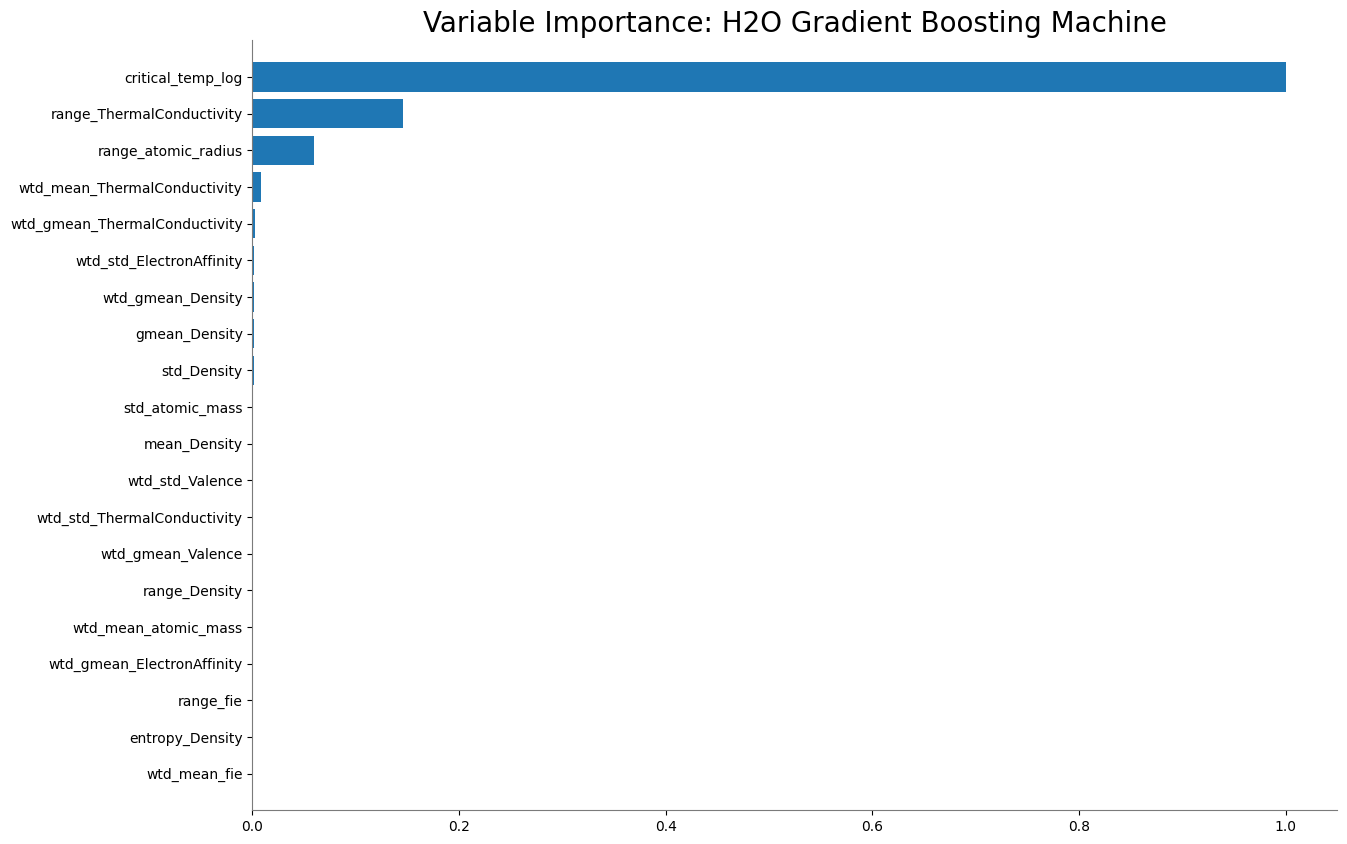

<Figure size 640x480 with 0 Axes>

In [43]:
## Feature importance: which features does GBM rely on?

# Again, pick the model you care about most
feat_model = gbm_timed  # or gbm_no_outliers, gbm_topK, etc.

print("=== Variable Importance (table) ===")
varimp_table = feat_model.varimp(use_pandas=True)
print(varimp_table.head(20))  # top 20

# Plot
feat_model.varimp_plot(num_of_features=20)
